In [1]:
import h5py
import matplotlib.pyplot as plt
import glob
import numpy as np
import torch
from starling.models.vae import VAE
from einops import rearrange
import hdf5plugin

In [24]:
def kl_between_distributions(mu1, logvar1, mu2, logvar2):
    # Assume shape: (batch_size, latent_dim)
    var1 = logvar1.exp()
    var2 = logvar2.exp()

    kl = 0.5 * torch.sum(
        logvar2 - logvar1 + (var1 + (mu1 - mu2).pow(2)) / var2 - 1,
        dim=1  # sum over latent dimensions
    )

    return kl.mean()  # average over batch

def mean_kl_to_unit_gaussian(mu, logvar):
    """
    Compute mean KL divergence from N(mu, sigma^2) to N(0, I)
    over a batch of latent parameters.
    
    Args:
        mu: Tensor of shape (batch_size, latent_dim)
        logvar: Tensor of shape (batch_size, latent_dim)
        
    Returns:
        Mean KL divergence (scalar)
    """
    kl = 0.5 * (mu.pow(2) + logvar.exp() - logvar - 1)
    kl_sum = kl.sum(dim=1)  # sum over latent dimensions
    return kl_sum.mean()    # mean over batch


def load_hdf5(filename):
    """
    Load an HDF5 file and return the data, strided along the first axis.
    """
    with h5py.File(filename, 'r') as f:
        data = f['latents'][:]
        return data

def encode_data(model, data):
    """
    Encodes data using the provided VAE model in batches of 32.

    Parameters:
    - model (VAE): The VAE model to use for encoding.
    - data (numpy.ndarray): Data to be encoded.

    Returns:
    - numpy.ndarray: Encoded data.
    """
    batch_size = 64
    device = next(model.parameters()).device  # Get model's device dynamically

    # Process data in batches
    encoded_means = []
    encoded_logvars = []
    with torch.no_grad():  # Move this outside the loop for efficiency
        # Process batches
        for i in range(0, len(data), batch_size):
            batch = data[i : i + batch_size]
            batch_tensor = torch.from_numpy(batch).to(device)
            batch_tensor = rearrange(batch_tensor, "b h w -> b 1 h w")
            moments = model.encode(batch_tensor)
            encoded_means.append(moments.mean.cpu().numpy())
            encoded_logvars.append(moments.logvar.cpu().numpy())

            # Optional: clear GPU memory (only if memory issues occur)
            # torch.cuda.empty_cache()

    # Concatenate all batches
    encoded_means = np.concatenate(encoded_means, axis=0).squeeze()
    encoded_logvars = np.concatenate(encoded_logvars, axis=0).squeeze()

    return encoded_means, encoded_logvars

# Load the VAE model
model = VAE.load_from_checkpoint(
    "/work/bnovak/projects/sequence2ensemble/starling/continuous_starling/encoder/model-kernel-epoch=99-epoch_val_loss=1.72.ckpt",
    map_location="cuda",
)
model.eval()

VAE(
  (encoder): ResNet_Encoder(
    (first_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (layer1): ModuleList(
      (0-1): 2 x ResBlockEncBasic(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation1): ReLU(inplace=True)
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (shortcut): Sequential()
        (activation): ReLU(inplace=True)
      )
    )
    (layer2): ModuleList(
      (0): ResBlockEncBasic(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm1): Instan

In [227]:
latents20mM_path = glob.glob('/work/bnovak/projects/sequence2ensemble/lammps_data/20mM_data/vae_1.72_model/*h5')
latents150mM_path = glob.glob('/work/bnovak/projects/sequence2ensemble/lammps_data/150mM_data/mPIPIgg_70k_seqs/IDR*/*/*h5')

In [228]:
latents20mM_path = [i for i in latents20mM_path if 'encoded' in i]
latents150mM_path = [i for i in latents150mM_path if 'encoded' in i]

In [229]:
latents20mM_path_subsampled = np.random.choice(latents20mM_path, size=1, replace=False)

In [230]:
# Get just the filenames (not paths) from latents20mM_path
latents20mM_names = set([p.split('/')[-1] for p in latents20mM_path_subsampled])

# Filter latents300mM_path to only those whose filename is in latents20mM_names
latents150mM_path_subsampled = [p for p in latents150mM_path if p.split('/')[-1] in latents20mM_names]

In [231]:
latents20mM = [load_hdf5(path) for path in latents20mM_path_subsampled]
latents150mM = [load_hdf5(path) for path in latents150mM_path_subsampled]

In [232]:
latents20mM = np.vstack(latents20mM)
latents150mM = np.vstack(latents150mM)

In [233]:
latents20mM = [arr.flatten() for arr in latents20mM]
latents150mM = [arr.flatten() for arr in latents150mM]

In [234]:
latents20mM = np.array(latents20mM)
latents150mM = np.array(latents150mM)

In [235]:
import numpy as np

X = np.concatenate([
    latents20mM, latents150mM,
], axis=0)

labels = (['20mM'] * len(latents20mM) +
          ['150mM'] * len(latents150mM))

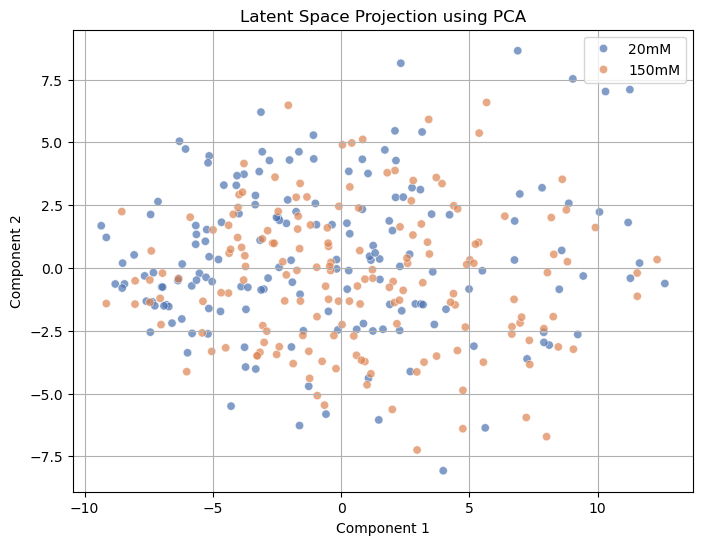

In [236]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_latents(X, labels, method='pca'):
    if method == 'pca':
        X_proj = PCA(n_components=2).fit_transform(X)
    elif method == 'tsne':
        X_proj = TSNE(n_components=2, perplexity=30, init='random', random_state=42).fit_transform(X)
    # elif method == 'umap':
        # X_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
    else:
        raise ValueError("method must be 'pca', 'tsne', or 'umap'")

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=labels, palette='deep', alpha=0.7)
    # sns.scatterplot(x=X_proj[:, 0][1000], y=X_proj[:, 1][1000], hue=labels, palette='deep', alpha=0.7)
    plt.title(f'Latent Space Projection using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_latents(X, labels, method='pca')   # Try also 'tsne' and 'umap'

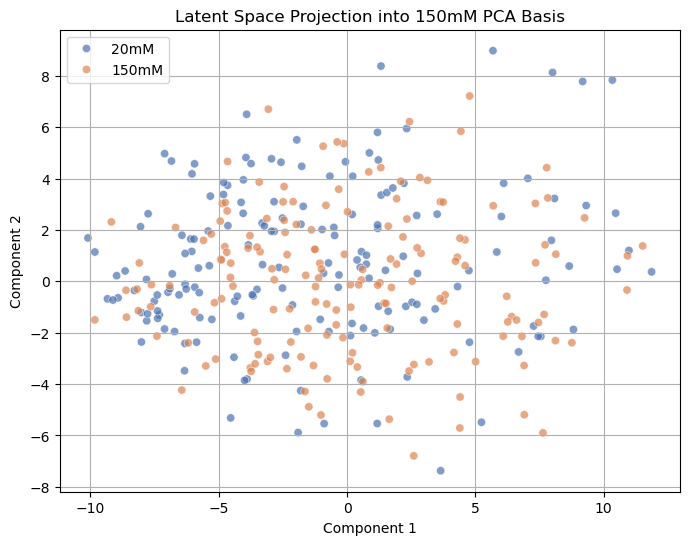

: 

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Fit PCA only on 150mM latents
pca = PCA(n_components=2)
pca.fit(latents150mM)  # Train PCA on VAE-trained distribution

# Step 2: Transform both 150mM and 20mM latents
latents150mM_proj = pca.transform(latents150mM)
latents20mM_proj = pca.transform(latents20mM)

# Step 3: Combine for plotting
X_proj = np.concatenate([latents20mM_proj, latents150mM_proj], axis=0)
labels = (['20mM'] * len(latents20mM) + ['150mM'] * len(latents150mM))

# Step 4: Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=labels, palette='deep', alpha=0.7)
plt.title('Latent Space Projection into 150mM PCA Basis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [208]:
latent_var = np.var(latents150mM, axis=0)  # shape: (latent_dim,)
total_variance = np.sum(latent_var)  # scalar

In [166]:
latent_var = np.var(latents150mM, axis=0)  # shape: (latent_dim,)
total_variance = np.sum(latent_var)  # scalar